<a href="https://colab.research.google.com/github/desstaw/Shortcut_Learning/blob/main/MNIST_foreground_SAE_muting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")
dir_path = "/content/drive/MyDrive/Masterthesis/Datasets/mnist"
#dir_path = "/content/drive/MyDrive/Projects/ISIC_224"

Mounted at /content/drive


In [ ]:
!pip install torchextractor

In [3]:
import torch
import sys
import numpy as np
import pickle as pkl
from os.path import join as oj
from datetime import datetime
import torch.optim as optim
import os
from torch.utils.data import TensorDataset, ConcatDataset
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score
import argparse
from PIL import Image
from tqdm import tqdm
from torch import nn
from numpy.random import randint
import torchvision.models as models
import time
import copy
import gc
import json
import pandas as pd
import torch
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import os
import gc
from sklearn.metrics import accuracy_score


### Loading fine tuned alexnet

In [4]:
# We no longer need to define a custome AlexNet
'''
class AlexNet(nn.Module):
    def __init__(self, width_mult=1):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),  # 96*55*55 (for 224x224 input)
            nn.MaxPool2d(kernel_size=3, stride=2),  # 96*27*27
            nn.ReLU(inplace=True),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, padding=2),  # 256*27*27
            nn.MaxPool2d(kernel_size=3, stride=2),  # 256*13*13
            nn.ReLU(inplace=True),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, padding=1),  # 384*13*13
            nn.ReLU(inplace=True),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, padding=1),  # 384*13*13
            nn.ReLU(inplace=True),
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),  # 256*13*13
            nn.MaxPool2d(kernel_size=3, stride=2),  # 256*6*6
            nn.ReLU(inplace=True),
        )
        self.fc1 = nn.Sequential(
            nn.Dropout(p=0.5),             # Dropout before first fully connected layer
            nn.Linear(256 * 1 * 1, 4096),  # First fully connected layer
            nn.ReLU(inplace=True),         # ReLU activation
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(p=0.5),             # Dropout before second fully connected layer
            nn.Linear(4096, 4096),         # Second fully connected layer
            nn.ReLU(inplace=True),         # ReLU activation
        )
        self.fc3 = nn.Linear(4096, 1000)  # Output layer (no activation here)

    def forward(self, x):
        # Pass through convolutional layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        # Flatten for fully connected layers
        x = x.view(-1, 256 * 1 * 1)

        # Pass through fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        # Return only the final output (as in the original code)
        return x
'''

In [5]:
class MnistDataset(Dataset):
    def __init__(self, path: str = None, is_two: int = None, data_files=None, labels=None, transform=None):
        self.resize_shape = (64, 64)  # Target shape for resizing images
        self.transform = transform or transforms.Compose([
            transforms.Resize(self.resize_shape),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for RGB images
        ])

        if path:
            self.path = path
            self.data_files = [f for f in os.listdir(self.path) if f.endswith(('.jpg', '.png'))]
            if len(self.data_files) == 0:
                raise ValueError(f"No valid image files found in the provided path: {self.path}")

            self.is_two = is_two
            self.labels = [is_two] * len(self.data_files) if is_two is not None else labels
        else:
            self.path = ''
            if data_files is None or len(data_files) == 0:
                raise ValueError("data_files must be a non-empty list of file paths.")

            self.data_files = data_files
            self.labels = labels
            self.is_two = is_two

        if self.labels is not None and len(self.labels) != len(self.data_files):
            raise ValueError("Mismatch between the number of labels and data files.")

    def __getitem__(self, i):
        try:
            img_path = os.path.join(self.path, self.data_files[i]) if self.path else self.data_files[i]
            img = Image.open(img_path).convert("RGB")
            if self.transform:
                img = self.transform(img)

            is_two = self.is_two if self.is_two is not None else self.labels[i]
            return img, is_two  # Exclude group_label
        except Exception as e:
            print(f"Error processing index {i}: {e}")
            return None

    def __len__(self):
        return len(self.data_files)


In [6]:
mean = np.asarray([0.485, 0.456, 0.406])
std = np.asarray([0.229, 0.224, 0.225])

'''
def load_model(model_path, device):
    print(f"Loading model from {model_path}")
    model = models.alexnet(pretrained=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.classifier[-1] = nn.Linear(4096, 2)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print("Model loaded successfully")
    return model
'''


# Function to load the trained model
def load_model(model_path, device):
    print(f"Loading model from {model_path}")
    model = models.alexnet(pretrained=False)
    model.classifier[-1] = nn.Linear(4096, 2)

    #model = AlexNet().to(device)
    #model.fc3 = nn.Linear(4096, 2)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print("Model loaded successfully")
    return model



# Function to test the model on a specific dataset
def test_model(model, dataloader, device):
    # Ensure the model is in evaluation mode. This disables dropout and batch norm updates.
    model.eval()

    # Variables to keep track of the total number of samples and correct predictions
    correct = 0  # Count of correctly classified samples
    total = 0    # Total number of samples processed

    # Disable gradient computation since we're only testing, not training
    with torch.no_grad():
        # Loop through the data in the dataloader
        for inputs, labels in dataloader:  # Assume dataloader returns (inputs, labels, additional_metadata)
            # Move the input images and labels to the specified device (CPU or GPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Perform a forward pass through the model to get outputs (logits for each class)
            outputs = model(inputs)

            # Use torch.max to get the predicted class with the highest logit (1st dimension: classes)
            _, predicted = torch.max(outputs, 1)

            # Increment total by the number of samples in the current batch
            total += labels.size(0)

            # Count the number of correct predictions by comparing with true labels
            correct += (predicted == labels).sum().item()

    # Compute accuracy as the percentage of correct predictions
    accuracy = correct / total * 100

    # Return the calculated accuracy
    return accuracy



# Define paths to the test datasets
test_two_fg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/foreground/test/class_2'
test_two_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2'

# Create test datasets
dataset_test_two_fg = MnistDataset(path=test_two_fg_path, is_two=1)
dataset_test_two_org = MnistDataset(path=test_two_org_path, is_two=1)

# Create dataloaders for the test datasets
batch_size = 64
test_loader_fg = DataLoader(dataset_test_two_fg, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_org = DataLoader(dataset_test_two_org, batch_size=batch_size, shuffle=False, num_workers=2)

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and test the model for each seed
seeds = [1, 11, 111]
for seed in seeds:
    model_path = f"/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_fg_seed_{seed}.pt"

    print(f"\nLoading model with seed {seed}")
    model = load_model(model_path, device)

    # Test on wb oatch dataset
    accuracy_fg = test_model(model, test_loader_fg, device)
    print(f"Accuracy on two with patch test dataset (class_2): {accuracy_fg:.2f}%")

    # Test on original dataset
    accuracy_org = test_model(model, test_loader_org, device)
    print(f"Accuracy on two without patch test dataset (class_2): {accuracy_org:.2f}%")



Loading model with seed 1
Loading model from /content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_fg_seed_1.pt


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-6-c1a57f678550>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

Model loaded successfully
Accuracy on two with patch test dataset (class_2): 0.00%
Accuracy on two without patch test dataset (class_2): 99.32%

Loading model with seed 11
Loading model from /content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_fg_seed_11.pt
Model loaded successfully
Accuracy on two with patch test dataset (class_2): 0.00%
Accuracy on two without patch test dataset (class_2): 99.61%

Loading model with seed 111
Loading model from /content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_fg_seed_111.pt
Model loaded successfully
Accuracy on two with patch test dataset (class_2): 0.00%
Accuracy on two without patch test dataset (class_2): 99.52%


### Extract Alexnet training fc2 activations

In [7]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None, resize_shape=(64, 64)):
        print(f"Initializing dataset with {len(image_paths)} images")
        self.image_paths = image_paths
        self.resize_shape = resize_shape  # Set the resize shape
        self.transform = transform or transforms.Compose([
            transforms.Resize(self.resize_shape),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for RGB images
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        print(f"Loading image: {image_path}")
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image


# Preprocessing function
preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((64, 64)),  # Match the resize shape in MnistDataset
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Match the normalization values in MnistDataset
])



In [8]:
def load_model(model_path):
    print(f"Loading model from {model_path}")
    model = models.alexnet(pretrained=True)
    #model = AlexNet().to(device)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    #model.fc3 = nn.Linear(4096, 2)
    model.classifier[-1] = nn.Linear(4096, 2)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print("Model loaded successfully")

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    print("Model loaded and layers frozen successfully")

    # Add a forward hook to capture fc2 activations
    activations = {}

    def hook(module, input, output):
        activations["fc2"] = output

    # Attach the hook to the second last layer (fc2)
    #model.fc2[1].register_forward_hook(hook)
    model.classifier[4].register_forward_hook(hook)

    return model, activations





def preprocess_and_extract_activations(model, dataloader, layer):

    activations = []
    with torch.no_grad():
        for batch in dataloader:
            image_tensor = batch[0]  # Extract the image tensor (ignore labels)
            image_tensor = image_tensor.to(device)

            if layer < 13:  # Layer in model.features
                tensor = image_tensor
                for idx, layer_module in enumerate(model.features[:layer + 1]):
                    tensor = layer_module(tensor)
            else:  # Layer in model.classifier
                tensor = model.features(image_tensor)
                tensor = model.avgpool(tensor)
                tensor = torch.flatten(tensor, 1)
                for idx, layer_module in enumerate(model.classifier[:layer - 12]):
                    tensor = layer_module(tensor)
                    if idx == 4:
                      print(f"Extracting from FC2 (classifier[4]): {layer_module}")
                      print(f"Activation shape at FC2: {tensor.shape}")


            activation = tensor.cpu().numpy()
            activations.append(activation)

    print(f"Extracted activations for {len(activations)} images")
    return activations


def process_images_in_folder(model, folder_path, layer, is_two, batch_size=1):
    all_layer_activations = []

    # Ensure folder_path is a string
    if not isinstance(folder_path, str):
        raise ValueError(f"Expected folder_path to be a string, but got {type(folder_path)}")

    # Get all image file paths
    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith(('.jpg', '.png'))]

    if len(image_paths) == 0:
        raise ValueError(f"No image files found in folder: {folder_path}")

    print(f"Initializing dataset with {len(image_paths)} images and is_two={is_two}")
    # Create the dataset and DataLoader
    dataset = ImageDataset(image_paths=image_paths, transform=preprocess)
    print(f"Dataset initialized with {len(dataset)} items.")
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Prepare dictionary for activations
    activations_dict = {}

    # Define the hook for the specified layer
    def hook(module, input, output):
        activations_dict[layer] = output

    # Register hook for the specified layer
    if layer == 'fc2':
        model.classifier[4].register_forward_hook(hook)  # Attach to fc2's Linear layer

    # Iterate over the dataloader to extract activations
    for images in dataloader:  # Only images are returned by the dataset
        if images is None:
            print("Skipping invalid batch.")
            continue

        images = images.to(next(model.parameters()).device)  # Move images to the same device as the model
        _ = model(images)  # Forward pass to trigger hooks

        # Collect activations from the specified layer
        if layer in activations_dict:
            all_layer_activations.append(activations_dict[layer].cpu().numpy())

    if len(all_layer_activations) == 0:
        raise ValueError("No activations were collected. Check dataset or model.")

    # Concatenate activations if batched
    all_layer_activations = np.concatenate(all_layer_activations, axis=0)

    # Free resources
    torch.cuda.empty_cache()
    gc.collect()

    return all_layer_activations




In [9]:
def flatten_and_align_activations(activations_list):
    print("Flattening and aligning activations")
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    print(f"Aligned activations to shape: {np.vstack(aligned_activations).shape}")
    return np.vstack(aligned_activations)


def save_activations(activations, folder_name, filename): #?????
    try:
        drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/individual/{folder_name}/alexnet_mnist_finetune_fg/{filename}.npy'
        os.makedirs(os.path.dirname(drive_path), exist_ok=True)
        print(f"Saving activations to {drive_path}")
        np.save(drive_path, activations)
    except Exception as e:
        print(f"Error saving activations to {drive_path}: {e}")

def load_activations(folder_name, filename):
    try:
        drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/individual/{folder_name}/alexnet_mnist_finetune_fg/{filename}.npy'
        print(f"Loading activations from {drive_path}")
        return np.load(drive_path, allow_pickle=True)
    except FileNotFoundError:
        print(f"Activations not found at {drive_path}")
        return None


In [10]:
import os
import random
import shutil

def move_images_to_new_folder(source_folder, destination_folder, percentage=20):
    """
    Moves a percentage of images from the source folder to the destination folder.

    Args:
        source_folder (str): Path to the source folder containing images.
        destination_folder (str): Path to the destination folder.
        percentage (int): Percentage of images to move. Default is 20%.
    """
    # Ensure the destination folder exists
    os.makedirs(destination_folder, exist_ok=True)

    # Get all files in the source folder
    image_files = [file for file in os.listdir(source_folder) if file.endswith(('.jpg', '.png', '.jpeg'))]

    # Calculate the number of images to move
    num_images_to_move = int(len(image_files) * (percentage / 100))
    print(f"Processing {source_folder}: Total images: {len(image_files)}. Moving {num_images_to_move} images.")

    # Randomly select images to move
    images_to_move = random.sample(image_files, num_images_to_move)

    # Move each selected image
    for image in images_to_move:
        source_path = os.path.join(source_folder, image)
        destination_path = os.path.join(destination_folder, image)
        shutil.move(source_path, destination_path)
        print(f"Moved: {source_path} -> {destination_path}")

    print(f"Successfully moved {num_images_to_move} images to {destination_folder}.\n")

# Source and destination folder mapping
folder_paths = {
    #'two_no_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_2',
    #'zero_no_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_0',
    'zero_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/foreground/train/class_0'
}

destination_paths = {
    #'two_no_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/val/class_2',
    #'zero_no_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/val/class_0',
    'zero_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/foreground/val/class_0'
}

# Move 20% of images from each folder
#for key in folder_paths.keys():
#    move_images_to_new_folder(folder_paths[key], destination_paths[key], percentage=20)


In [ ]:
def compute_activations_for_layers(model_paths, folder_paths, layers, activations_file_prefix):
    # Initialize the dictionary with all keys in folder_paths
    all_layer_activations = {layer: {key: [] for key in folder_paths.keys()} for layer in layers}

    for folder_name, folder_path in folder_paths.items():
        print(f"Processing folder {folder_name}")

        # Get the is_two value from the mapping
        is_two = is_two_mapping.get(folder_name)
        if is_two is None:
            raise ValueError(f"Unknown folder name: {folder_name}. Please update is_two_mapping.")

        for layer in layers:
            for model_idx, model_path in enumerate(model_paths):
                print(f"Processing model {model_idx + 1}/{len(model_paths)}")

                # Define the specific activation file path
                model_specific_file_prefix = f'{activations_file_prefix}_model{model_idx + 1}_{folder_name}'
                activation_file_path = f'layer_{layer}_{model_specific_file_prefix}.npy'

                # Check if the activation file already exists
                if os.path.exists(activation_file_path):
                    print(f"Activation file {activation_file_path} already exists. Skipping computation.")
                    # Load existing activations to the dictionary
                    existing_activations = np.load(activation_file_path, allow_pickle=True)
                    all_layer_activations[layer][folder_name].append(existing_activations)
                    continue

                # Load the model
                model, activations_dict = load_model(model_path)

                def hook(module, input, output):
                    activations_dict[layer] = output

                # Register the forward hook for the specified layer
                model.classifier[4].register_forward_hook(hook)

                # Compute activations
                activations = process_images_in_folder(model, folder_path, layer, is_two=is_two, batch_size=1)
                activations = flatten_and_align_activations(activations)

                # Save activations for this model and folder
                save_activations(activations, f'layer_{layer}', model_specific_file_prefix)

                # Add activations to the dictionary
                all_layer_activations[layer][folder_name].append(activations)

                # Cleanup to free memory
                del model
                torch.cuda.empty_cache()
                gc.collect()

    return all_layer_activations







# Step 2: Extract Training Activations

model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_fg_seed_1.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_fg_seed_11.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_fg_seed_111.pt"
]

layers_of_interest = ['fc2']

is_two_mapping = {
    'two_no_patch': 1,
    'zero_no_patch': 0,
    'zero_patch': 0
}


# Paths to training data
train_folder_paths = {
    'two_no_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_2',
    'zero_no_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_0',
    'zero_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/foreground/train/class_0'
}


val_folder_paths = {
    'two_no_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/val/class_2',
    'zero_no_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/val/class_0',
    'zero_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/foreground/val/class_0'
}


# Extract and save averaged training activations across three models
#train_activations = compute_activations_for_layers(model_paths, train_folder_paths, layers_of_interest, 'train')
#val_activations = compute_activations_for_layers(model_paths, val_folder_paths, layers_of_interest, 'val')

In [12]:
'''

# Define paths to the activation files
base_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/activations/average/layer_17/'
activation_files = ['train_wb_nopatch.npy', 'train_lb_nopatch.npy', 'train_lb_patch.npy']

# Function to calculate statistics for a given activations file
def analyze_activations(file_path):
    activations = np.load(file_path)
    num_samples, num_neurons = activations.shape

    # Ensure activations have 4096 neurons for fc2
    if num_neurons != 4096:
        print(f"Warning: Expected 4096 neurons but got {num_neurons} in {file_path}")

    # Compute basic statistics
    stats = {
        'Number of Samples': num_samples,
        'Number of Neurons': num_neurons,
        'Mean Activation': np.mean(activations, axis=0),
        'Std Activation': np.std(activations, axis=0),
        'Median Activation': np.median(activations, axis=0),
        'Min Activation': np.min(activations, axis=0),
        'Max Activation': np.max(activations, axis=0),
    }
    return stats

# Analyze and print results for each file
for file_name in activation_files:
    file_path = os.path.join(base_path, file_name)
    print(f"Analyzing {file_name}...")

    # Perform analysis
    stats = analyze_activations(file_path)

    # Display the results
    print(f"Results for {file_name}:")
    print(f"Number of Images Processed: {stats['Number of Samples']}")
    print(f"Number of Activations per Image: {stats['Number of Neurons']}")
    print(f"Overall Mean Activation: {np.mean(stats['Mean Activation']):.4f}")
    print(f"Overall Std of Activations: {np.mean(stats['Std Activation']):.4f}")
    print(f"Overall Median Activation: {np.median(stats['Median Activation']):.4f}")
    print(f"Min Activation Value (across neurons): {np.min(stats['Min Activation']):.4f}")
    print(f"Max Activation Value (across neurons): {np.max(stats['Max Activation']):.4f}")
    print("-" * 50)
'''

'\n\n# Define paths to the activation files\nbase_path = \'/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/activations/average/layer_17/\'\nactivation_files = [\'train_wb_nopatch.npy\', \'train_lb_nopatch.npy\', \'train_lb_patch.npy\']\n\n# Function to calculate statistics for a given activations file\ndef analyze_activations(file_path):\n    activations = np.load(file_path)\n    num_samples, num_neurons = activations.shape\n\n    # Ensure activations have 4096 neurons for fc2\n    if num_neurons != 4096:\n        print(f"Warning: Expected 4096 neurons but got {num_neurons} in {file_path}")\n\n    # Compute basic statistics\n    stats = {\n        \'Number of Samples\': num_samples,\n        \'Number of Neurons\': num_neurons,\n        \'Mean Activation\': np.mean(activations, axis=0),\n        \'Std Activation\': np.std(activations, axis=0),\n        \'Median Activation\': np.median(activations, axis=0),\n        \'Min Activation\': np.min(activations, axis=0),\n        \'Max A

### Load saved activations of the fc2 alexnet training to later train the SAE

In [18]:
import os
import numpy as np

def load_saved_activations(subset, activations_file_prefix, model_idx=None, dataset_type="train"):
    """
    Load saved activations from files with the format: {dataset_type}_model{idx}_{subset}.npy.

    Parameters:
        subset (str): The data subset (e.g., "two_no_patch", "zero_no_patch", "zero_patch").
        activations_file_prefix (str): File prefix for the activations.
        model_idx (int or None): Specific model index to load (e.g., 1, 2, 3). If None, load all models.
        dataset_type (str): The dataset type ("train" or "val").

    Returns:
        np.ndarray or List[np.ndarray]: Loaded activations for a specific model (if model_idx is provided)
                                        or a list of activations for all models.
    """
    activations = []

    if model_idx is not None:
        # Load activations for a specific model
        drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/individual/layer_fc2/{dataset_type}_model{model_idx}_{subset}.npy'
        print(f"Loading activations from {drive_path}")

        if os.path.exists(drive_path):
            model_activations = np.load(drive_path, allow_pickle=True)
            print(f"Loaded activations for subset {subset}, dataset {dataset_type}, model {model_idx}. Shape: {model_activations.shape}")
            return model_activations
        else:
            print(f"Activations file {drive_path} does not exist.")
            return None
    else:
        # Load activations for all models
        for idx in range(1, 4):  # Adjust the range based on the number of models
            drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/individual/layer_fc2/{dataset_type}_model{idx}_{subset}.npy'
            print(f"Loading activations from {drive_path}")

            if os.path.exists(drive_path):
                model_activations = np.load(drive_path, allow_pickle=True)
                print(f"Loaded activations for subset {subset}, dataset {dataset_type}, model {idx}. Shape: {model_activations.shape}")
                activations.append(model_activations)
            else:
                print(f"Activations file {drive_path} does not exist.")

        if len(activations) > 0:
            print(f"Loaded activations for {len(activations)} model(s).")
            return activations  # List of numpy arrays, one for each model
        else:
            print("No activations files found.")
            return None


In [19]:
# Step 2: Define Sparse Autoencoder with KL-divergence
class SparseAutoencoder(nn.Module):
    def __init__(self, in_dims, h_dims, sparsity_lambda=1e-3, sparsity_target=0.10, xavier_norm_init=True):
        super(SparseAutoencoder, self).__init__()
        self.in_dims = in_dims  # Input dimension (number of neurons in the input layer)
        self.h_dims = h_dims  # Hidden dimension (number of neurons in the hidden layer)
        self.sparsity_lambda = sparsity_lambda  # Weight for the sparsity penalty term
        self.sparsity_target = sparsity_target  # Target sparsity (desired average activation)

        # Encoder: Projects input to the hidden (sparse) space
        self.encoder = nn.Sequential(
            nn.Linear(self.in_dims, self.h_dims),
            nn.ReLU()
        )
        if xavier_norm_init:
            nn.init.xavier_uniform_(self.encoder[0].weight)  # Xavier initialization

        # Decoder: Reconstructs the input from the hidden (sparse) representation
        self.decoder = nn.Sequential(
            nn.Linear(self.h_dims, self.in_dims),
            nn.ReLU()
        )
        if xavier_norm_init:
            nn.init.xavier_uniform_(self.decoder[0].weight)

    # Forward pass through the encoder and decoder
    def forward(self, x):
        encoded = self.encoder(x)  # Pass input through encoder
        decoded = self.decoder(encoded)  # Pass encoded (sparse) representation through decoder
        return encoded, decoded

    # KL-divergence sparsity penalty calculation
    def sparsity_penalty(self, encoded):
        rho_hat = torch.mean(encoded, dim=0)  # Compute the average activation for each hidden neuron
        rho = torch.ones_like(rho_hat) * self.sparsity_target  # Target sparsity value
        epsilon = 1e-8  # Small value to avoid log(0)
        kl_divergence = F.kl_div((rho_hat + epsilon).log(), rho + epsilon, reduction='batchmean')  # KL-divergence
        return self.sparsity_lambda * kl_divergence  # Return the sparsity penalty, weighted by lambda

    # Loss function combining MSE (reconstruction error) and sparsity penalty
    def loss_function(self, decoded, original, encoded):
        mse_loss = F.mse_loss(decoded, original)  # Mean Squared Error for reconstruction
        sparsity_loss = self.sparsity_penalty(encoded)  # Sparsity penalty for hidden layer activations
        return mse_loss + sparsity_loss  # Total loss is MSE + sparsity penalty

'''
# Early stopping mechanism to prevent overfitting
class EarlyStopping:
    def __init__(self, patience=30, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta  # Minimum change to qualify as an improvement
        self.best_loss = None  # Best validation loss observed so far
        self.counter = 0  # Counter to keep track of how many epochs since the last improvement

    # Check if training should be stopped based on validation loss
    def check(self, loss):
        if self.best_loss is None:
            self.best_loss = loss  # Set the initial best loss
            return False

        # If the loss has improved significantly
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss  # Update best loss
            self.counter = 0  # Reset counter
            return False
        else:
            self.counter += 1  # Increment counter if no improvement
            if self.counter >= self.patience:
                print("Early stopping triggered.")  # Stop training if patience is exceeded
                return True
        return False


# Training Function with Loss Tracking and Plotting
def train_autoencoder(autoencoder, train_data, val_data, num_epochs=500, batch_size=128, learning_rate=1e-5, validation_split=0.2, clip_gradients=True, max_grad_norm=0.5):
    #print(f"Training autoencoder with input dim {data.shape[1]} and encoding dim {autoencoder.h_dims}")

    # Split the data into training and validation sets
    #num_train = int((1 - validation_split) * len(data))  # Compute the number of training samples
    #train_data = data[:num_train]  # Training data
    #val_data = data[num_train:]  # Validation data

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_tensor = torch.from_numpy(train_data).float()
    val_tensor = torch.from_numpy(val_data).float()
    # Create PyTorch datasets and dataloaders for training and validation
    train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_data).float())
    val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(val_data).float())
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Adam optimizer with learning rate and weight decay for regularization
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=1e-2)

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=50, min_delta=0.001)

    # Lists to store training and validation loss values
    train_losses = []
    val_losses = []

    # Start training loop
    autoencoder.train()  # Set the autoencoder in training mode
    for epoch in range(num_epochs):
        total_train_loss = 0  # Initialize training loss for the current epoch

        # Iterate over batches in the training set
        for x_batch, in train_loader:
            x_batch = x_batch.to(device)
            optimizer.zero_grad()  # Zero the gradients
            encoded, decoded = autoencoder(x_batch)  # Forward pass through autoencoder
            loss = autoencoder.loss_function(decoded, x_batch, encoded)  # Compute the loss
            loss.backward()  # Backpropagate the error

            # Apply gradient clipping if enabled
            if clip_gradients:
                torch.nn.utils.clip_grad_norm_(autoencoder.parameters(), max_grad_norm)

            optimizer.step()  # Update the weights using the optimizer
            total_train_loss += loss.item()  # Accumulate training loss for this batch

        # Validation step after each epoch
        total_val_loss = 0  # Initialize validation loss
        autoencoder.eval()  # Set the autoencoder in evaluation mode
        with torch.no_grad():  # No gradient calculation in validation mode
            for x_batch, in val_loader:
                x_batch = x_batch.to(device)
                encoded, decoded = autoencoder(x_batch)
                loss = autoencoder.loss_function(decoded, x_batch, encoded)
                total_val_loss += loss.item()

        # Compute the average training and validation loss for this epoch
        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)

        # Store the loss values for plotting later
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Print progress for the current epoch
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')

        # Check early stopping condition based on validation loss
        if early_stopping.check(avg_val_loss):
            break

    print("Autoencoder training completed")

    # Plot the training and validation loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    return autoencoder



Training autoencoders for layer fc2

Processing activations for layer fc2, seed 1 (Model 1)

Train files associated with seed 1:
  - Subset: two_no_patch, File: train_model1_two_no_patch.npy
  - Subset: zero_no_patch, File: train_model1_zero_no_patch.npy
  - Subset: zero_patch, File: train_model1_zero_patch.npy
Combined train activations shape for layer fc2, seed 1: (9504, 4096)

Validation files associated with seed 1:
  - Subset: two_no_patch, File: val_model1_two_no_patch.npy
  - Subset: zero_no_patch, File: val_model1_zero_no_patch.npy
  - Subset: zero_patch, File: val_model1_zero_patch.npy
Combined val activations shape for layer fc2, seed 1: (2375, 4096)
Training autoencoder for layer fc2 (unnormalized, seed 1)
Epoch 1/500, Train Loss: 0.8919122799237569, Val Loss: 0.6862719906003851
Epoch 2/500, Train Loss: 0.5826400864124298, Val Loss: 0.49256466093816254
Epoch 3/500, Train Loss: 0.4483831902345022, Val Loss: 0.40116398271761444
Epoch 4/500, Train Loss: 0.37927053252855936, Va

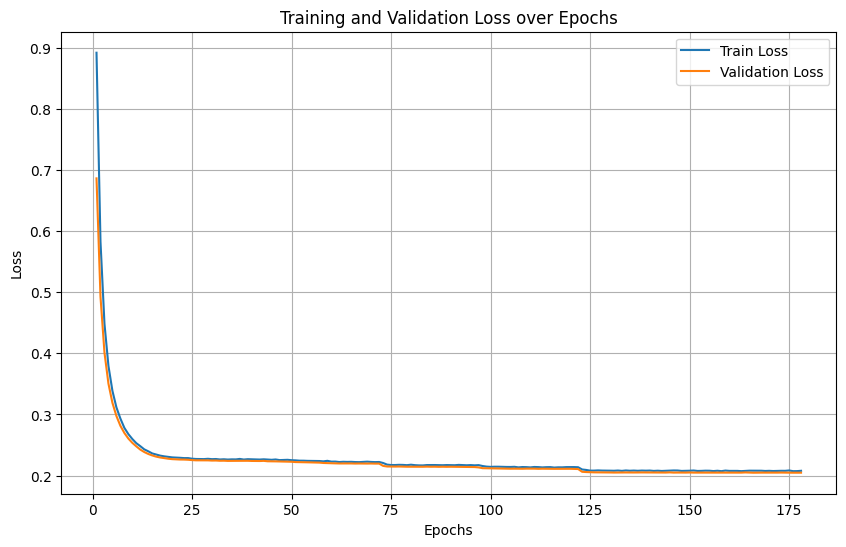

Saved unnormalized autoencoder at /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/Autoencoders/mnist_fg/fg_autoencoder_layer_fc2_seed_1_unnormalized.pth

Processing activations for layer fc2, seed 11 (Model 2)

Train files associated with seed 11:
  - Subset: two_no_patch, File: train_model2_two_no_patch.npy
  - Subset: zero_no_patch, File: train_model2_zero_no_patch.npy
  - Subset: zero_patch, File: train_model2_zero_patch.npy
Combined train activations shape for layer fc2, seed 11: (9504, 4096)

Validation files associated with seed 11:
  - Subset: two_no_patch, File: val_model2_two_no_patch.npy
  - Subset: zero_no_patch, File: val_model2_zero_no_patch.npy
  - Subset: zero_patch, File: val_model2_zero_patch.npy
Combined val activations shape for layer fc2, seed 11: (2375, 4096)
Training autoencoder for layer fc2 (unnormalized, seed 11)
Epoch 1/500, Train Loss: 0.9710185821851095, Val Loss: 0.747212428795664
Epoch 2/500, Train Loss: 0.619070075750351, Val Loss: 0.515777

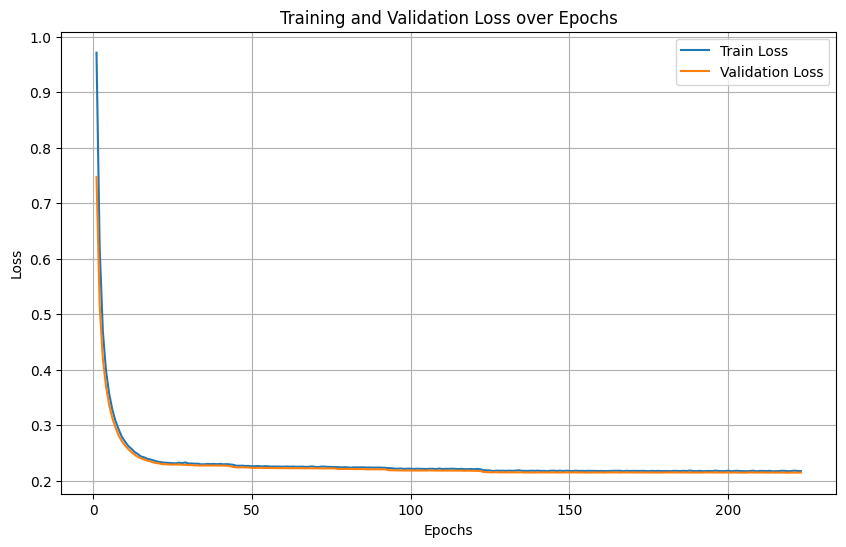

Saved unnormalized autoencoder at /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/Autoencoders/mnist_fg/fg_autoencoder_layer_fc2_seed_11_unnormalized.pth

Processing activations for layer fc2, seed 111 (Model 3)

Train files associated with seed 111:
  - Subset: two_no_patch, File: train_model3_two_no_patch.npy
  - Subset: zero_no_patch, File: train_model3_zero_no_patch.npy
  - Subset: zero_patch, File: train_model3_zero_patch.npy
Combined train activations shape for layer fc2, seed 111: (9504, 4096)

Validation files associated with seed 111:
  - Subset: two_no_patch, File: val_model3_two_no_patch.npy
  - Subset: zero_no_patch, File: val_model3_zero_no_patch.npy
  - Subset: zero_patch, File: val_model3_zero_patch.npy
Combined val activations shape for layer fc2, seed 111: (2375, 4096)
Training autoencoder for layer fc2 (unnormalized, seed 111)
Epoch 1/500, Train Loss: 0.932160894870758, Val Loss: 0.7185591678870352
Epoch 2/500, Train Loss: 0.6094195095698038, Val Loss: 

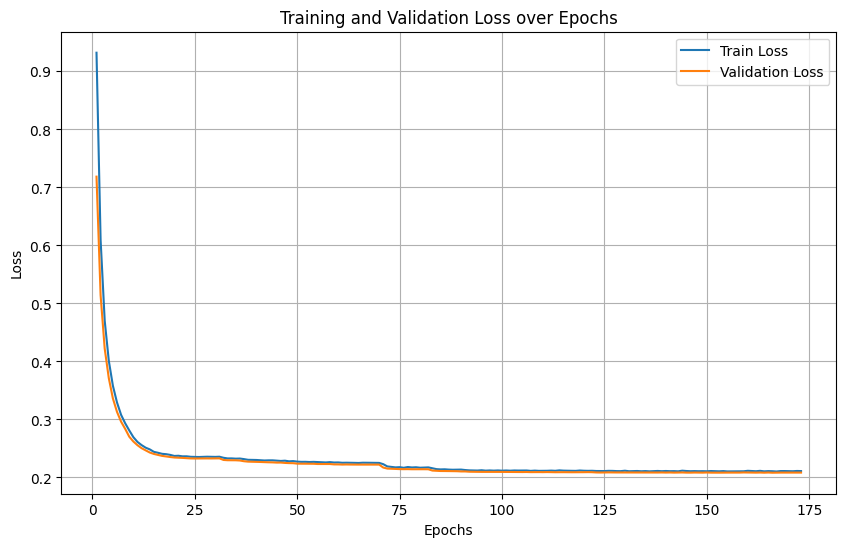

Saved unnormalized autoencoder at /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/Autoencoders/mnist_fg/fg_autoencoder_layer_fc2_seed_111_unnormalized.pth

All autoencoders trained and saved successfully.


In [21]:
# Define the directory to save autoencoders trained on normalized activations
save_sae_dir = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/Autoencoders/mnist_fg'  # Directory to save the trained autoencoder
os.makedirs(save_sae_dir, exist_ok=True)
'''
# Iterate through layers of interest
for layer in layers_of_interest:
    print(f'\nTraining autoencoders for layer {layer}')

    # Iterate through seeds (corresponding to models)
    for seed_idx, seed in enumerate([1, 11, 111], start=1):
        print(f"\nProcessing activations for layer {layer}, seed {seed} (Model {seed_idx})")

        # Get training activations for the current seed and layer
        train_activations_list = []
        print(f"\nTrain files associated with seed {seed}:")
        for subset in ['two_no_patch', 'zero_no_patch', 'zero_patch']:
            if subset in train_activations[layer]:
                subset_activations = train_activations[layer][subset][seed_idx - 1]  # Seed index starts from 1, Python lists are 0-based
                train_activations_list.append(subset_activations)
                print(f"  - Subset: {subset}, File: train_model{seed_idx}_{subset}.npy")
            else:
                print(f"Warning: No train activations found for subset {subset}, layer {layer}, seed {seed}.")

        if len(train_activations_list) == 0:
            print(f"No train activations found for layer {layer}, seed {seed}. Skipping...")
            continue

        # Combine train activations
        combined_train_activations = np.vstack(train_activations_list)
        print(f"Combined train activations shape for layer {layer}, seed {seed}: {combined_train_activations.shape}")

        # Get validation activations for the current seed and layer
        val_activations_list = []
        print(f"\nValidation files associated with seed {seed}:")
        for subset in ['two_no_patch', 'zero_no_patch', 'zero_patch']:
            if subset in val_activations[layer]:
                subset_activations = val_activations[layer][subset][seed_idx - 1]
                val_activations_list.append(subset_activations)
                print(f"  - Subset: {subset}, File: val_model{seed_idx}_{subset}.npy")
            else:
                print(f"Warning: No val activations found for subset {subset}, layer {layer}, seed {seed}.")

        if len(val_activations_list) == 0:
            print(f"No val activations found for layer {layer}, seed {seed}. Skipping...")
            continue

        # Combine val activations
        combined_val_activations = np.vstack(val_activations_list)
        print(f"Combined val activations shape for layer {layer}, seed {seed}: {combined_val_activations.shape}")

        # Set the random seed for reproducibility
        torch.manual_seed(seed)
        np.random.seed(seed)

        # Define encoding dimension
        encoding_dim = 8192

        # Train autoencoder on unnormalized activations
        autoencoder = SparseAutoencoder(combined_train_activations.shape[1], encoding_dim).to(device)
        print(f"Training autoencoder for layer {layer} (unnormalized, seed {seed})")
        autoencoder = train_autoencoder(autoencoder, combined_train_activations, combined_val_activations,
                                        num_epochs=500, learning_rate=1e-5)

        # Save the trained autoencoder
        save_path_unnormalized = os.path.join(
            save_sae_dir, f'fg_autoencoder_layer_{layer}_seed_{seed}_unnormalized.pth'
        )
        torch.save(autoencoder.state_dict(), save_path_unnormalized)
        print(f"Saved unnormalized autoencoder at {save_path_unnormalized}")

        # Clear memory
        del autoencoder
        torch.cuda.empty_cache()
        gc.collect()

print("\nAll autoencoders trained and saved successfully.")
'''

In [22]:
# Load the pre-trained autoencoder for layer 6 (fc2) (from snippet 4)
def load_autoencoder(device, save_sae_dir):
    """
    Load a pre-trained sparse autoencoder and freeze its parameters.
    """
    input_dims = 4096
    encoding_dim = 8192

    # Initialize the autoencoder
    autoencoder = SparseAutoencoder(input_dims, encoding_dim)
    autoencoder.load_state_dict(torch.load(save_sae_dir))  # Load weights
    autoencoder = autoencoder.to(device)  # Move model to device

    # Freeze all parameters of the autoencoder
    for param in autoencoder.parameters():
        param.requires_grad = False

    # Set the autoencoder to evaluation mode
    autoencoder.eval()
    print(f"Autoencoder loaded from {save_sae_dir} and frozen successfully.")
    return autoencoder



####################

def load_model(saved_weights_path, device):
    """
    Loads a trained PyTorch AlexNet model, freezes all layers up to fc2,
    and prepares it for passing activations through classifier[5] and classifier[6].

    Args:
        saved_weights_path (str): Path to the saved weights of the trained AlexNet model.
        device (torch.device): The device to load the model onto (e.g., torch.device('cuda') or torch.device('cpu')).

    Returns:
        torch.nn.Module: The loaded and partially frozen PyTorch AlexNet model.
    """
    # Load the PyTorch AlexNet model
    print(f"Loading model from {saved_weights_path}")
    model = models.alexnet(pretrained=False)  # Load AlexNet without pretrained weights
    model.classifier[-1] = nn.Linear(4096, 2)  # Update the last layer for binary classification

    # Load the saved weights
    model.load_state_dict(torch.load(saved_weights_path, map_location=device))
    model.to(device)

    # Freeze all layers except `classifier[5]` (ReLU) and `classifier[6]` (fc3)
    for name, param in model.named_parameters():
        if name.startswith("classifier.6"):  # classifier[6] corresponds to fc3
            param.requires_grad = True
        elif name.startswith("classifier.5"):  # ReLU does not have trainable params
            param.requires_grad = True
        else:
            param.requires_grad = False

    # Set the model to evaluation mode
    model.eval()
    print("Model loaded and all layers up to fc2 are frozen")
    return model






In [23]:
from pathlib import Path

base_dir = "/content/drive/MyDrive/Masterthesis/Datasets/mnist"
activation_dir = os.path.join(base_dir, "activations")
output_base_dir = os.path.join(base_dir, "outputs")
Path(output_base_dir).mkdir(parents=True, exist_ok=True)



# Define paths for pre-saved activations
def get_activation_path(folder_name, filename):
    return os.path.join(activation_dir, folder_name, f"{filename}.npy")


def extract_fc2_activations(model, dataloader):
    """
    Extract activations from the fc2 layer (classifier[4]) of the PyTorch AlexNet.
    Args:
        model: Pretrained or fine-tuned PyTorch AlexNet model.
        dataloader: DataLoader for the test set.

    Returns:
        numpy.ndarray: Activations from fc2 for all images in the dataloader.
    """
    print("Extracting AlexNet activations for layer fc2...")
    activations = []

    # Ensure the model is in evaluation mode
    model.eval()

    with torch.no_grad():  # Disable gradient computation
        for batch_idx, (image_tensor, _) in enumerate(dataloader):  # Expect only 2 elements: (img, is_two)
            # Move image tensor to the device (CPU or GPU)
            image_tensor = image_tensor.to(device)

            # Pass through the feature extractor
            features = model.features(image_tensor)
            features = model.avgpool(features)  # Apply average pooling
            features = torch.flatten(features, 1)  # Flatten for classifier input

            # Pass through classifier layers up to fc2
            for idx, layer in enumerate(model.classifier):
                features = layer(features)
                if idx == 4:  # Stop after fc2 (classifier[4])
                    activations.append(features.cpu().numpy())
                    break

            # Log progress
            if (batch_idx + 1) % 10 == 0:
                print(f"Processed {batch_idx + 1}/{len(dataloader)} batches")

            # Clear resources
            torch.cuda.empty_cache()
            gc.collect()

    # Stack activations into a single array
    return np.vstack(activations)




def load_or_extract_fc2_activations(model, dataloader, folder_name, filename):
    # Generate activation file path
    activation_path = get_activation_path(folder_name, filename)

    # Check if the activation file exists
    if os.path.exists(activation_path):
        print(f"Loading pre-saved AlexNet activations for {filename} from {activation_path}...")
        activations = np.load(activation_path, allow_pickle=True)
    else:
        print(f"No pre-saved AlexNet activations found for {filename}. Extracting and saving...")
        activations = extract_fc2_activations(model, dataloader)  # Extract activations
        os.makedirs(os.path.dirname(activation_path), exist_ok=True)  # Ensure directory exists
        np.save(activation_path, activations)  # Save activations
        print(f"Activations for layer fc2 saved to {activation_path}")

    return activations




In [ ]:
from sklearn.metrics import accuracy_score
'''
def main():
    # Paths and initialization
    model_paths = [
        "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_fg_seed_1.pt",
        "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_fg_seed_11.pt",
        "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_fg_seed_111.pt"
    ]

    # Define dataset paths
    dataset_paths = {
        "test_two_fg": '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/foreground/test/class_2',
        "test_two_org": '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2',
        "test_zero_fg": '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/foreground/test/class_0',
        "test_zero_org": '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_0',
        "val_two_org": '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/val/class_2',
        "val_zero_org": '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/val/class_0',
        "val_zero_fg": '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/foreground/val/class_0'
    }
    # Prepare dataloaders
    dataloaders = {}
    for key, folder in dataset_paths.items():
        image_paths = [
            os.path.join(root, file)
            for root, dirs, files in os.walk(folder)
            for file in files if file.endswith(('.jpg', '.png'))
        ]
        # Use is_two = 1 if "two" is in the key, else 0
        dataset = MnistDataset(data_files=image_paths, is_two=1 if "two" in key else 0)
        dataloaders[key] = DataLoader(dataset, batch_size=1, shuffle=False)

    # Directory for saving results
    sparse_output_dir = "/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/alexnet_mnist_finetune_fg"
    os.makedirs(sparse_output_dir, exist_ok=True)

    # Loop over models
    for model_path in model_paths:
        print(f"Processing model: {model_path}")

        # Load the model
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = load_model(model_path, device)

        # Process each dataset
        for key, loader in dataloaders.items():
            print(f"Processing dataset: {key}")

            # Extract activations
            activations = load_or_extract_fc2_activations(
                model, loader, f'{key}_{Path(model_path).stem}', f'fg_fc2_activations_{key}_{Path(model_path).stem}'
            )

            # Save activations
            activation_path = os.path.join(sparse_output_dir, f"fc2_activations_{key}_{Path(model_path).stem}.npy")
            np.save(activation_path, activations)
            print(f"Activations for {key} saved to: {activation_path}")

main()
'''

continue starting from here

In [40]:
from sklearn.metrics import accuracy_score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function 12 to classify decoded activations
def classify_decoded_activations(model, decoded_activations):
    """Classify decoded activations using the softmax layer of the model."""
    predictions = []
    for activation in decoded_activations:
        # Convert numpy activation to a tensor
        activation_tensor = torch.from_numpy(activation).float().to(device)

        # Pass through classifier[5] (ReLU)
        relu_output = model.classifier[5](activation_tensor)

        # Pass through classifier[6] (final linear layer)
        output = model.classifier[6](relu_output)

        # Apply softmax and get the predicted class
        prediction = torch.argmax(torch.nn.functional.softmax(output, dim=0)).item()
        predictions.append(prediction)

    return predictions


# Project activations into sparse space
def project_activations(autoencoder, activations, device):
    print("Projecting Alexnet activations into SAE sparse space...")
    with torch.no_grad():
        projected = autoencoder.encoder(torch.from_numpy(activations).to(device).float())
    return projected.cpu().numpy()

# Save all neuron differences and indexes in descending order
def save_all_neurons_to_csv(abs_diff, folder_name, filename="fg_all_neuron_differences.csv"):
    """
    Save all neuron indexes sorted by their differences (descending order) to a CSV file.
    """
    print(f"Saving all neuron differences to CSV file: {filename}")

    # Create a DataFrame with neuron indices and their absolute differences
    neuron_data = pd.DataFrame({
        "Neuron_Index": np.arange(len(abs_diff)),
        "Activation_Difference": abs_diff
    })

    # Sort by absolute difference in descending order
    neuron_data.sort_values(by="Activation_Difference", ascending=False, inplace=True)

    # Save the DataFrame to a CSV file
    csv_path = os.path.join(folder_name, filename)
    neuron_data.to_csv(csv_path, index=False)
    print(f"CSV saved at: {csv_path}")

    return csv_path # return the csv_path



def save_top_neurons_to_csv(abs_diff, top_neurons, folder_name, filename="fg_top_neurons.csv"):
    """
    Save the top neurons with their difference values to a CSV file.
    """
    print(f"Saving top neurons to CSV file: {filename}")

    # Create a DataFrame with neuron indices and their absolute differences
    neuron_data = pd.DataFrame({
        "Neuron_Index": range(len(abs_diff)),
        "Activation_Difference": abs_diff
    })

    # Mark whether each neuron is in the top 10%
    neuron_data["Selected_for_Muting"] = neuron_data["Neuron_Index"].isin(top_neurons)

    # Sort by absolute difference in descending order
    neuron_data.sort_values(by="Activation_Difference", ascending=False, inplace=True)

    # Save the DataFrame to a CSV file
    csv_path = os.path.join(folder_name, filename)
    neuron_data.to_csv(csv_path, index=False)
    print(f"CSV saved at: {csv_path}")

# Function to load top neurons from CSV based on a percentage
def load_top_neurons_from_csv(folder_name, filename, percentage):
    """
    Load top neurons based on the specified percentage from the saved CSV file.
    """
    csv_path = os.path.join(folder_name, filename)
    neuron_data = pd.read_csv(csv_path)

    # Calculate the number of top neurons to select
    top_count = int(len(neuron_data) * (percentage / 100))

    # Select the top neurons based on their activation difference
    top_neurons = neuron_data.iloc[:top_count]["Neuron_Index"].values
    print(f"Loaded top {percentage}% neurons ({top_count} neurons) for muting.")
    return top_neurons


def classify_with_alexnet(model, activations):
    """
    Classify images using the original AlexNet classifier on the fc2 activations.
    """
    predictions = []
    for activation in activations:
        # Convert numpy activation to tensor
        activation_tensor = torch.from_numpy(activation).float().to(device)
        relu_output = model.classifier[5](activation_tensor)  # Apply ReLU
        output = model.classifier[6](relu_output)  # Apply fc3
        prediction = torch.argmax(torch.nn.functional.softmax(output, dim=0)).item()
        predictions.append(prediction)
    return predictions

# Function to calculate accuracy per group
def calculate_group_accuracy(predictions, true_labels):
    return accuracy_score(true_labels, predictions)



def main():

    seeds = [1, 11, 111]

    # Paths to models, activations, and autoencoders for each seed
    model_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_fg_seed_{seed}.pt"
        for seed in seeds
    ]
    autoencoder_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/Autoencoders/mnist_fg/fg_autoencoder_layer_fc2_seed_{seed}_unnormalized.pth"
        for seed in seeds
    ]
    test_activation_two_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/alexnet_mnist_finetune_fg/fc2_activations_test_two_fg_alexnet_mnist_fg_seed_{seed}.npy"
        for seed in seeds
    ]
    test_activation_two_no_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/alexnet_mnist_finetune_fg/fc2_activations_test_two_org_alexnet_mnist_fg_seed_{seed}.npy"
        for seed in seeds
    ]
    test_activation_zero_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/alexnet_mnist_finetune_fg/fc2_activations_test_zero_fg_alexnet_mnist_fg_seed_{seed}.npy"
        for seed in seeds
    ]
    test_activation_zero_no_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/alexnet_mnist_finetune_fg/fc2_activations_test_zero_org_alexnet_mnist_fg_seed_{seed}.npy"
        for seed in seeds
    ]
    val_activation_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/alexnet_mnist_finetune_fg/fc2_activations_val_zero_fg_alexnet_mnist_fg_seed_{seed}.npy"
        for seed in seeds
    ]
    val_activation_no_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/alexnet_mnist_finetune_fg/fc2_activations_val_zero_org_alexnet_mnist_fg_seed_{seed}.npy"
        for seed in seeds
    ]

    # Output folder for results
    folder_name = "/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/difference_analysis/alexnet_mnist_finetune_fg"
    os.makedirs(folder_name, exist_ok=True)

    all_results = []

    # Loop through seeds/models/autoencoders
    for seed_idx, seed in enumerate(seeds):

        print(f"\nProcessing Seed {seed}")
        model_path = model_paths[seed_idx]
        sae_path = autoencoder_paths[seed_idx]
        val_patch_path = val_activation_patch_paths[seed_idx]
        val_no_patch_path = val_activation_no_patch_paths[seed_idx]
        test_two_patch_path = test_activation_two_patch_paths[seed_idx]
        test_two_no_patch_path = test_activation_two_no_patch_paths[seed_idx]
        test_zero_patch_path = test_activation_zero_patch_paths[seed_idx]
        test_zero_no_patch_path = test_activation_zero_no_patch_paths[seed_idx]

        print(f"Model Path: {model_path}")
        print(f"Autoencoder Path: {sae_path}")
        print(f"Validation Patch Path: {val_patch_path}")
        print(f"Validation No Patch Path: {val_no_patch_path}")
        print(f"Test Two Patch Path: {test_two_patch_path}")
        print(f"Test Two No Patch Path: {test_two_no_patch_path}")
        print(f"Test Zero Patch Path: {test_zero_patch_path}")
        print(f"Test Zero No Patch Path: {test_zero_no_patch_path}")

        # Load the model and autoencoder
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = load_model(model_path, device)
        autoencoder = load_autoencoder(device, sae_path)

        # Load pre-saved activations
        val_activations_patch = np.load(val_patch_path, allow_pickle=True)
        val_activations_no_patch = np.load(val_no_patch_path, allow_pickle=True)

        # Direct classification using AlexNet
        predictions_val_patch_alexnet = classify_with_alexnet(model, val_activations_patch)
        accuracy_val_patch_alexnet = accuracy_score([0] * len(predictions_val_patch_alexnet), predictions_val_patch_alexnet)

        predictions_val_no_patch_alexnet = classify_with_alexnet(model, val_activations_no_patch)
        accuracy_no_patch_alexnet = accuracy_score([0] * len(predictions_val_no_patch_alexnet), predictions_val_no_patch_alexnet)

        # Classification before muting
        predictions_val_patch_before = classify_with_alexnet(model, val_activations_patch)
        predictions_val_no_patch_before = classify_with_alexnet(model, val_activations_no_patch)

        # Calculate validation accuracies before muting
        accuracy_val_patch_before = calculate_group_accuracy(predictions_val_patch_before, [0] * len(predictions_val_patch_before))
        accuracy_val_no_patch_before = calculate_group_accuracy(predictions_val_no_patch_before, [0] * len(predictions_val_no_patch_before))



        # Project validation activations into sparse space
        projected_val_patch = project_activations(autoencoder, val_activations_patch, device)
        projected_val_no_patch = project_activations(autoencoder, val_activations_no_patch, device)

        # Calculate differences and save neuron indexes
        avg_val_patch = np.mean(projected_val_patch, axis=0)
        avg_val_no_patch = np.mean(projected_val_no_patch, axis=0)
        abs_diff = np.abs(avg_val_patch - avg_val_no_patch)
        csv_path = save_all_neurons_to_csv(abs_diff, folder_name, filename=f"mnist_fg_val_neuron_differences_seed_{seed}.csv")

        csv_folder = "/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/difference_analysis/alexnet_mnist_finetune_fg"
        csv_filename = f"val_neuron_differences_seed_{seed}.csv"
        neurons_to_mute = load_top_neurons_from_csv(csv_folder, filename=f"mnist_fg_val_neuron_differences_seed_{seed}.csv", percentage = 0.5)
        #neurons_to_mute = top_neurons[:int(len(top_neurons) * 0.1)]
        projected_val_patch[:, neurons_to_mute] = 0
        projected_val_no_patch[:, neurons_to_mute] = 0

        decoded_val_patch = autoencoder.decoder(torch.from_numpy(projected_val_patch).to(device).float()).cpu().numpy()
        decoded_val_no_patch = autoencoder.decoder(torch.from_numpy(projected_val_no_patch).to(device).float()).cpu().numpy()

        predictions_val_patch_after = classify_decoded_activations(model, decoded_val_patch)
        predictions_val_no_patch_after = classify_decoded_activations(model, decoded_val_no_patch)

        accuracy_val_patch_after = calculate_group_accuracy(predictions_val_patch_after, [0] * len(predictions_val_patch_after))
        accuracy_val_no_patch_after = calculate_group_accuracy(predictions_val_no_patch_after, [0] * len(predictions_val_no_patch_after))

        # Print Validation Results
        print(f"Validation Accuracy (Patch, Before Muting): {accuracy_val_patch_before:.4f}")
        print(f"Validation Accuracy (No Patch, Before Muting): {accuracy_val_no_patch_before:.4f}")
        print(f"Validation Accuracy (Patch, After Muting): {accuracy_val_patch_after:.4f}")
        print(f"Validation Accuracy (No Patch, After Muting): {accuracy_val_no_patch_after:.4f}")

############################################################################################################################################
        # Test Phase
        test_two_patch = np.load(test_activation_two_patch_paths[seed_idx], allow_pickle=True)
        test_two_no_patch = np.load(test_activation_two_no_patch_paths[seed_idx], allow_pickle=True)
        test_zero_patch = np.load(test_activation_zero_patch_paths[seed_idx], allow_pickle=True)
        test_zero_no_patch = np.load(test_activation_zero_no_patch_paths[seed_idx], allow_pickle=True)



        # Test classification before muting
        predictions_test_two_patch_before = classify_with_alexnet(model, test_two_patch)
        predictions_test_two_no_patch_before = classify_with_alexnet(model, test_two_no_patch)
        predictions_test_zero_patch_before = classify_with_alexnet(model, test_zero_patch)
        predictions_test_zero_no_patch_before = classify_with_alexnet(model, test_zero_no_patch)



        accuracy_test_two_patch_before = calculate_group_accuracy(predictions_test_two_patch_before, [1] * len(predictions_test_two_patch_before))
        accuracy_test_two_no_patch_before = calculate_group_accuracy(predictions_test_two_no_patch_before, [1] * len(predictions_test_two_no_patch_before))
        accuracy_test_zero_patch_before = calculate_group_accuracy(predictions_test_zero_patch_before, [0] * len(predictions_test_zero_patch_before))
        accuracy_test_zero_no_patch_before = calculate_group_accuracy(predictions_test_zero_no_patch_before, [0] * len(predictions_test_zero_no_patch_before))

        # Load top neurons from validation
        top_neurons = load_top_neurons_from_csv(csv_folder, filename=f"mnist_fg_val_neuron_differences_seed_{seed}.csv", percentage=0.5)

        # Project test activations into sparse space
        projected_two_test_patch = project_activations(autoencoder, test_two_patch, device)
        projected_two_test_no_patch = project_activations(autoencoder, test_two_no_patch, device)
        projected_zero_test_patch = project_activations(autoencoder, test_zero_patch, device)
        projected_zero_test_no_patch = project_activations(autoencoder, test_zero_no_patch, device)

        #top_neuron_count = int(len(abs_diff) * 0.1)
        #top_neurons = np.argsort(abs_diff)[-top_neuron_count:]

        # Muting neurons in test data
        percentage = 10
        neurons_to_mute = load_top_neurons_from_csv(csv_folder, filename=f"mnist_fg_val_neuron_differences_seed_{seed}.csv", percentage = 0.5)
        projected_two_test_patch[:, neurons_to_mute] = 0
        projected_two_test_no_patch[:, neurons_to_mute] = 0
        projected_zero_test_patch[:, neurons_to_mute] = 0
        projected_zero_test_no_patch[:, neurons_to_mute] = 0


        # Decode and classify test data
        decoded_two_test_patch = autoencoder.decoder(torch.from_numpy(projected_two_test_patch).to(device).float()).cpu().detach().numpy()
        decoded_two_test_no_patch = autoencoder.decoder(torch.from_numpy(projected_two_test_no_patch).to(device).float()).cpu().detach().numpy()
        decoded_zero_test_patch = autoencoder.decoder(torch.from_numpy(projected_zero_test_patch).to(device).float()).cpu().detach().numpy()
        decoded_zero_test_no_patch = autoencoder.decoder(torch.from_numpy(projected_zero_test_no_patch).to(device).float()).cpu().detach().numpy()

        # Classification
        predictions_test_two_patch_after = classify_decoded_activations(model, decoded_two_test_patch)
        predictions_test_two_no_patch_after = classify_decoded_activations(model, decoded_two_test_no_patch)
        predictions_test_zero_patch_after = classify_decoded_activations(model, decoded_zero_test_patch)
        predictions_test_zero_no_patch_after = classify_decoded_activations(model, decoded_zero_test_no_patch)

        accuracy_test_two_patch_after = calculate_group_accuracy(predictions_test_two_patch_after, [1] * len(predictions_test_two_patch_after))
        accuracy_test_two_no_patch_after = calculate_group_accuracy(predictions_test_two_no_patch_after, [1] * len(predictions_test_two_no_patch_after))
        accuracy_test_zero_patch_after = calculate_group_accuracy(predictions_test_zero_patch_after, [0]* len(predictions_test_zero_patch_after))
        accuracy_test_zero_no_patch_after = calculate_group_accuracy(predictions_test_zero_no_patch_after, [0] * len(predictions_test_zero_no_patch_after))

        # Calculate Worst and Average Group Accuracies
        worst_group_accuracy_before = min(accuracy_test_two_patch_before, accuracy_test_two_no_patch_before)
        worst_group_accuracy_after = min(accuracy_test_two_patch_after, accuracy_test_two_no_patch_after)

        # Calculate the average group accuracy correctly by dividing the sum of accuracies by 4
        avg_group_accuracy_before = (accuracy_test_two_patch_before + accuracy_test_two_no_patch_before + accuracy_test_zero_patch_before + accuracy_test_zero_no_patch_before) / 4
        avg_group_accuracy_after = (accuracy_test_two_patch_after + accuracy_test_two_no_patch_after + accuracy_test_zero_patch_after + accuracy_test_zero_no_patch_after) / 4
        # Print Test Results
        print(f"Test Accuracy (Patch, Before Muting): {accuracy_test_two_patch_before:.4f}")
        print(f"Test Accuracy (No Patch, Before Muting): {accuracy_test_two_no_patch_before:.4f}")
        print(f"Test Accuracy (Patch, After Muting): {accuracy_test_zero_patch_after:.4f}")
        print(f"Test Accuracy (No Patch, After Muting): {accuracy_test_zero_no_patch_after:.4f}")
        print(f"Worst Group Accuracy (Before Muting): {worst_group_accuracy_before:.4f}")
        print(f"Worst Group Accuracy (After Muting): {worst_group_accuracy_after:.4f}")
        print(f"Average Group Accuracy (Before Muting): {avg_group_accuracy_before:.4f}")
        print(f"Average Group Accuracy (After Muting): {avg_group_accuracy_after:.4f}")


if __name__ == "__main__":
    main()



Processing Seed 1
Model Path: /content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_fg_seed_1.pt
Autoencoder Path: /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/Autoencoders/mnist_fg/fg_autoencoder_layer_fc2_seed_1_unnormalized.pth
Validation Patch Path: /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/alexnet_mnist_finetune_fg/fc2_activations_val_zero_fg_alexnet_mnist_fg_seed_1.npy
Validation No Patch Path: /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/alexnet_mnist_finetune_fg/fc2_activations_val_zero_org_alexnet_mnist_fg_seed_1.npy
Test Two Patch Path: /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/alexnet_mnist_finetune_fg/fc2_activations_test_two_fg_alexnet_mnist_fg_seed_1.npy
Test Two No Patch Path: /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/alexnet_mnist_finetune_fg/fc2_activations_test_two_org_alexnet_mnist_fg_seed_1.npy
Test Zero Patch Path: /content/drive/

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-22-e2d7d9f833b7>:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Model loaded and all layers up to fc2 are frozen


<ipython-input-22-e2d7d9f833b7>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(save_sae_dir))  # Load weights


Autoencoder loaded from /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/Autoencoders/mnist_fg/fg_autoencoder_layer_fc2_seed_1_unnormalized.pth and frozen successfully.
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Saving all neuron differences to CSV file: mnist_fg_val_neuron_differences_seed_1.csv
CSV saved at: /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/difference_analysis/alexnet_mnist_finetune_fg/mnist_fg_val_neuron_differences_seed_1.csv
Loaded top 0.5% neurons (40 neurons) for muting.
Validation Accuracy (Patch, Before Muting): 1.0000
Validation Accuracy (No Patch, Before Muting): 0.9983
Validation Accuracy (Patch, After Muting): 0.0338
Validation Accuracy (No Patch, After Muting): 0.9155
Loaded top 0.5% neurons (40 neurons) for muting.
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-22-e2d7d9f833b7>:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Model loaded and all layers up to fc2 are frozen


<ipython-input-22-e2d7d9f833b7>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(save_sae_dir))  # Load weights


Autoencoder loaded from /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/Autoencoders/mnist_fg/fg_autoencoder_layer_fc2_seed_11_unnormalized.pth and frozen successfully.
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Saving all neuron differences to CSV file: mnist_fg_val_neuron_differences_seed_11.csv
CSV saved at: /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/difference_analysis/alexnet_mnist_finetune_fg/mnist_fg_val_neuron_differences_seed_11.csv
Loaded top 0.5% neurons (40 neurons) for muting.
Validation Accuracy (Patch, Before Muting): 1.0000
Validation Accuracy (No Patch, Before Muting): 1.0000
Validation Accuracy (Patch, After Muting): 0.0321
Validation Accuracy (No Patch, After Muting): 0.9341
Loaded top 0.5% neurons (40 neurons) for muting.
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations i

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-22-e2d7d9f833b7>:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Model loaded and all layers up to fc2 are frozen


<ipython-input-22-e2d7d9f833b7>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(save_sae_dir))  # Load weights


Autoencoder loaded from /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/Autoencoders/mnist_fg/fg_autoencoder_layer_fc2_seed_111_unnormalized.pth and frozen successfully.
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Saving all neuron differences to CSV file: mnist_fg_val_neuron_differences_seed_111.csv
CSV saved at: /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/difference_analysis/alexnet_mnist_finetune_fg/mnist_fg_val_neuron_differences_seed_111.csv
Loaded top 0.5% neurons (40 neurons) for muting.
Validation Accuracy (Patch, Before Muting): 1.0000
Validation Accuracy (No Patch, Before Muting): 0.9949
Validation Accuracy (Patch, After Muting): 0.0574
Validation Accuracy (No Patch, After Muting): 0.9223
Loaded top 0.5% neurons (40 neurons) for muting.
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activation

In [44]:
from sklearn.metrics import accuracy_score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function 12 to classify decoded activations
def classify_decoded_activations(model, decoded_activations):
    """Classify decoded activations using the softmax layer of the model."""
    predictions = []
    for activation in decoded_activations:
        # Convert numpy activation to a tensor
        activation_tensor = torch.from_numpy(activation).float().to(device)

        # Pass through classifier[5] (ReLU)
        relu_output = model.classifier[5](activation_tensor)

        # Pass through classifier[6] (final linear layer)
        output = model.classifier[6](relu_output)

        # Apply softmax and get the predicted class
        prediction = torch.argmax(torch.nn.functional.softmax(output, dim=0)).item()
        predictions.append(prediction)

    return predictions


# Project activations into sparse space
def project_activations(autoencoder, activations, device):
    print("Projecting Alexnet activations into SAE sparse space...")
    with torch.no_grad():
        projected = autoencoder.encoder(torch.from_numpy(activations).to(device).float())
    return projected.cpu().numpy()

# Save all neuron differences and indexes in descending order
def save_all_neurons_to_csv(abs_diff, folder_name, filename="all_neuron_differences.csv"):
    """
    Save all neuron indexes sorted by their differences (descending order) to a CSV file.
    """
    print(f"Saving all neuron differences to CSV file: {filename}")

    # Create a DataFrame with neuron indices and their absolute differences
    neuron_data = pd.DataFrame({
        "Neuron_Index": np.arange(len(abs_diff)),
        "Activation_Difference": abs_diff
    })

    # Sort by absolute difference in descending order
    neuron_data.sort_values(by="Activation_Difference", ascending=False, inplace=True)

    # Save the DataFrame to a CSV file
    csv_path = os.path.join(folder_name, filename)
    neuron_data.to_csv(csv_path, index=False)
    print(f"CSV saved at: {csv_path}")

    return csv_path # return the csv_path

def save_neurons_by_correlation(val_patch_activations, val_no_patch_activations, folder_name, filename="neurons_by_correlation.csv"):
    """
    Save neurons sorted by their correlation between val_patch_activations and val_no_patch_activations.
    """
    print(f"Calculating neuron correlations and saving to {filename}")

    # Compute the correlation for each neuron across the two groups
    correlations = np.array([
        np.corrcoef(val_patch_activations[:, i], val_no_patch_activations[:, i])[0, 1]
        if np.std(val_patch_activations[:, i]) > 0 and np.std(val_no_patch_activations[:, i]) > 0
        else 0  # Set correlation to 0 if one group has constant values
        for i in range(val_patch_activations.shape[1])
    ])

    # Handle NaN correlations (replace NaN with 0)
    correlations = np.nan_to_num(correlations)

    # Create a DataFrame with neuron indices and their correlations
    neuron_data = pd.DataFrame({
        "Neuron_Index": np.arange(len(correlations)),
        "Correlation": correlations
    })

    # Sort by absolute correlation in ascending order (low correlation first)
    neuron_data.sort_values(by="Correlation", ascending=True, inplace=True)

    # Save the DataFrame to a CSV file
    csv_path = os.path.join(folder_name, filename)
    neuron_data.to_csv(csv_path, index=False)
    print(f"Neuron correlations saved at: {csv_path}")

    return csv_path



def save_top_neurons_to_csv(abs_diff, top_neurons, folder_name, filename="dlp_top_neurons.csv"):
    """
    Save the top neurons with their difference values to a CSV file.
    """
    print(f"Saving top neurons to CSV file: {filename}")

    # Create a DataFrame with neuron indices and their absolute differences
    neuron_data = pd.DataFrame({
        "Neuron_Index": range(len(abs_diff)),
        "Activation_Difference": abs_diff
    })

    # Mark whether each neuron is in the top 10%
    neuron_data["Selected_for_Muting"] = neuron_data["Neuron_Index"].isin(top_neurons)

    # Sort by absolute difference in descending order
    neuron_data.sort_values(by="Activation_Difference", ascending=False, inplace=True)

    # Save the DataFrame to a CSV file
    csv_path = os.path.join(folder_name, filename)
    neuron_data.to_csv(csv_path, index=False)
    print(f"CSV saved at: {csv_path}")

# Function to load top neurons from CSV based on a percentage
def load_top_neurons_from_csv(folder_name, filename, percentage):
    """
    Load top neurons based on the specified percentage from the saved CSV file.
    """
    csv_path = os.path.join(folder_name, filename)
    neuron_data = pd.read_csv(csv_path)

    # Calculate the number of top neurons to select
    top_count = int(len(neuron_data) * (percentage / 100))

    # Select the top neurons based on their activation difference
    top_neurons = neuron_data.iloc[:top_count]["Neuron_Index"].values

    # Debugging for 0% muting
    if percentage == 0:
        assert len(top_neurons) == 0, "Top neurons list should be empty for 0% muting."

    print(f"Loaded top {percentage}% neurons ({top_count} neurons) for muting.")
    return top_neurons


def classify_with_alexnet(model, activations):
    """
    Classify images using the original AlexNet classifier on the fc2 activations.
    """
    predictions = []
    for activation in activations:
        # Convert numpy activation to tensor
        activation_tensor = torch.from_numpy(activation).float().to(device)
        relu_output = model.classifier[5](activation_tensor)  # Apply ReLU
        output = model.classifier[6](relu_output)  # Apply fc3
        prediction = torch.argmax(torch.nn.functional.softmax(output, dim=0)).item()
        predictions.append(prediction)
    return predictions

# Function to calculate accuracy per group
def calculate_group_accuracy(predictions, true_labels):
    return accuracy_score(true_labels, predictions)


def main():
    import pandas as pd
    import os
    import numpy as np
    import torch

    seeds = [1, 11, 111]

    # Paths to models, activations, and autoencoders for each seed
    model_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_fg_seed_{seed}.pt"
        for seed in seeds
    ]
    autoencoder_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/Autoencoders/mnist_fg/fg_autoencoder_layer_fc2_seed_{seed}_unnormalized.pth"
        for seed in seeds
    ]
    test_activation_two_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/alexnet_mnist_finetune_fg/fc2_activations_test_two_fg_alexnet_mnist_fg_seed_{seed}.npy"
        for seed in seeds
    ]
    test_activation_two_no_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/alexnet_mnist_finetune_fg/fc2_activations_test_two_org_alexnet_mnist_fg_seed_{seed}.npy"
        for seed in seeds
    ]
    test_activation_zero_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/alexnet_mnist_finetune_fg/fc2_activations_test_zero_fg_alexnet_mnist_fg_seed_{seed}.npy"
        for seed in seeds
    ]
    test_activation_zero_no_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/alexnet_mnist_finetune_fg/fc2_activations_test_zero_org_alexnet_mnist_fg_seed_{seed}.npy"
        for seed in seeds
    ]
    val_activation_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/alexnet_mnist_finetune_fg/fc2_activations_val_zero_fg_alexnet_mnist_fg_seed_{seed}.npy"
        for seed in seeds
    ]
    val_activation_no_patch_paths = [
        f"/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/alexnet_mnist_finetune_fg/fc2_activations_val_zero_org_alexnet_mnist_fg_seed_{seed}.npy"
        for seed in seeds
    ]

    # Output folder for results
    folder_name = "/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/difference_analysis/alexnet_mnist_finetune_fg"
    os.makedirs(folder_name, exist_ok=True)

    # Prepare a DataFrame to store results
    results_df = pd.DataFrame(columns=[
        "Seed", "Percentage",
        "Val_Patch_Before", "Val_NoPatch_Before",
        "Val_Patch_After", "Val_NoPatch_After",
        "Test_Two_Patch_Before", "Test_Two_NoPatch_Before",
        "Test_Two_Patch_After", "Test_Two_NoPatch_After",
        "Test_Zero_Patch_Before", "Test_Zero_NoPatch_Before",
        "Test_Zero_Patch_After", "Test_Zero_NoPatch_After",
        "Worst_Acc_Before", "Worst_Acc_After",
        "Avg_Acc_Before", "Avg_Acc_After"
    ])

    # Loop through seeds/models/autoencoders
    for seed_idx, seed in enumerate(seeds):
        print(f"\nProcessing Seed {seed}")

        # Load paths
        model_path = model_paths[seed_idx]
        sae_path = autoencoder_paths[seed_idx]
        val_patch_path = val_activation_patch_paths[seed_idx]
        val_no_patch_path = val_activation_no_patch_paths[seed_idx]
        test_two_patch_path = test_activation_two_patch_paths[seed_idx]
        test_two_no_patch_path = test_activation_two_no_patch_paths[seed_idx]
        test_zero_patch_path = test_activation_zero_patch_paths[seed_idx]
        test_zero_no_patch_path = test_activation_zero_no_patch_paths[seed_idx]

        # Load the model and autoencoder
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = load_model(model_path, device)
        autoencoder = load_autoencoder(device, sae_path)

        # Load pre-saved activations
        val_activations_patch = np.load(val_patch_path, allow_pickle=True)
        val_activations_no_patch = np.load(val_no_patch_path, allow_pickle=True)

        test_two_patch = np.load(test_two_patch_path, allow_pickle=True)
        test_two_no_patch = np.load(test_two_no_patch_path, allow_pickle=True)
        test_zero_patch = np.load(test_zero_patch_path, allow_pickle=True)
        test_zero_no_patch = np.load(test_zero_no_patch_path, allow_pickle=True)

        # Classify "before muting"
        predictions_val_patch_before = classify_with_alexnet(model, val_activations_patch)
        predictions_val_no_patch_before = classify_with_alexnet(model, val_activations_no_patch)
        accuracy_val_patch_before = calculate_group_accuracy(predictions_val_patch_before, [0] * len(predictions_val_patch_before))
        accuracy_val_no_patch_before = calculate_group_accuracy(predictions_val_no_patch_before, [0] * len(predictions_val_no_patch_before))

        predictions_test_two_patch_before = classify_with_alexnet(model, test_two_patch)
        predictions_test_two_no_patch_before = classify_with_alexnet(model, test_two_no_patch)
        predictions_test_zero_patch_before = classify_with_alexnet(model, test_zero_patch)
        predictions_test_zero_no_patch_before = classify_with_alexnet(model, test_zero_no_patch)

        accuracy_test_two_patch_before = calculate_group_accuracy(predictions_test_two_patch_before, [1] * len(predictions_test_two_patch_before))
        accuracy_test_two_no_patch_before = calculate_group_accuracy(predictions_test_two_no_patch_before, [1] * len(predictions_test_two_no_patch_before))
        accuracy_test_zero_patch_before = calculate_group_accuracy(predictions_test_zero_patch_before, [0] * len(predictions_test_zero_patch_before))
        accuracy_test_zero_no_patch_before = calculate_group_accuracy(predictions_test_zero_no_patch_before, [0] * len(predictions_test_zero_no_patch_before))

        # Project activations
        projected_val_patch = project_activations(autoencoder, val_activations_patch, device)
        projected_val_no_patch = project_activations(autoencoder, val_activations_no_patch, device)
        projected_two_test_patch = project_activations(autoencoder, test_two_patch, device)
        projected_two_test_no_patch = project_activations(autoencoder, test_two_no_patch, device)
        projected_zero_test_patch = project_activations(autoencoder, test_zero_patch, device)
        projected_zero_test_no_patch = project_activations(autoencoder, test_zero_no_patch, device)

        # Loop through percentages
        for percentage in range(0, 16):  # 1% to 15%
            print(f"Testing with {percentage}% muting...")

            # Calculate differences and load top neurons
            abs_diff = np.abs(np.mean(projected_val_patch, axis=0) - np.mean(projected_val_no_patch, axis=0))
            csv_path = save_all_neurons_to_csv(abs_diff, folder_name, filename=f"mnist_fg_val_neuron_differences_seed_{seed}.csv")
            top_neurons = load_top_neurons_from_csv(folder_name, f"mnist_fg_val_neuron_differences_seed_{seed}.csv", percentage)

            # **Correlation-Based Neurons**
            correlation_csv_path = save_neurons_by_correlation(
                projected_val_patch, projected_val_no_patch, folder_name, filename=f"neurons_by_correlation_seed_{seed}.csv"
            )
            top_neurons_corr = load_top_neurons_from_csv(folder_name, f"neurons_by_correlation_seed_{seed}.csv", percentage)

            #top_neurons = top_neurons_corr

            # Muting neurons
            projected_val_patch_muted = projected_val_patch.copy()
            projected_val_no_patch_muted = projected_val_no_patch.copy()
            projected_two_test_patch_muted = projected_two_test_patch.copy()
            projected_two_test_no_patch_muted = projected_two_test_no_patch.copy()
            projected_zero_test_patch_muted = projected_zero_test_patch.copy()
            projected_zero_test_no_patch_muted = projected_zero_test_no_patch.copy()

            projected_val_patch_muted[:, top_neurons] = 0
            projected_val_no_patch_muted[:, top_neurons] = 0
            projected_two_test_patch_muted[:, top_neurons] = 0
            projected_two_test_no_patch_muted[:, top_neurons] = 0
            projected_zero_test_patch_muted[:, top_neurons] = 0
            projected_zero_test_no_patch_muted[:, top_neurons] = 0

            # Decode and classify
            decoded_val_patch = autoencoder.decoder(torch.from_numpy(projected_val_patch_muted).to(device).float()).cpu().numpy()
            decoded_val_no_patch = autoencoder.decoder(torch.from_numpy(projected_val_no_patch_muted).to(device).float()).cpu().numpy()
            decoded_two_test_patch = autoencoder.decoder(torch.from_numpy(projected_two_test_patch_muted).to(device).float()).cpu().numpy()
            decoded_two_test_no_patch = autoencoder.decoder(torch.from_numpy(projected_two_test_no_patch_muted).to(device).float()).cpu().numpy()
            decoded_zero_test_patch = autoencoder.decoder(torch.from_numpy(projected_zero_test_patch_muted).to(device).float()).cpu().numpy()
            decoded_zero_test_no_patch = autoencoder.decoder(torch.from_numpy(projected_zero_test_no_patch_muted).to(device).float()).cpu().numpy()

            predictions_val_patch_after = classify_decoded_activations(model, decoded_val_patch)
            predictions_val_no_patch_after = classify_decoded_activations(model, decoded_val_no_patch)
            predictions_test_two_patch_after = classify_decoded_activations(model, decoded_two_test_patch)
            predictions_test_two_no_patch_after = classify_decoded_activations(model, decoded_two_test_no_patch)
            predictions_test_zero_patch_after = classify_decoded_activations(model, decoded_zero_test_patch)
            predictions_test_zero_no_patch_after = classify_decoded_activations(model, decoded_zero_test_no_patch)

            accuracy_val_patch_after = calculate_group_accuracy(predictions_val_patch_after, [0] * len(predictions_val_patch_after))
            accuracy_val_no_patch_after = calculate_group_accuracy(predictions_val_no_patch_after, [0] * len(predictions_val_no_patch_after))
            accuracy_test_two_patch_after = calculate_group_accuracy(predictions_test_two_patch_after, [1] * len(predictions_test_two_patch_after))
            accuracy_test_two_no_patch_after = calculate_group_accuracy(predictions_test_two_no_patch_after, [1] * len(predictions_test_two_no_patch_after))
            accuracy_test_zero_patch_after = calculate_group_accuracy(predictions_test_zero_patch_after, [0] * len(predictions_test_zero_patch_after))
            accuracy_test_zero_no_patch_after = calculate_group_accuracy(predictions_test_zero_no_patch_after, [0] * len(predictions_test_zero_no_patch_after))

            # Calculate worst and average group accuracies
            worst_acc_before = min(accuracy_test_two_patch_before, accuracy_test_two_no_patch_before)
            worst_acc_after = min(accuracy_test_two_patch_after, accuracy_test_two_no_patch_after)
            avg_acc_before = (accuracy_test_two_patch_before + accuracy_test_two_no_patch_before +
                              accuracy_test_zero_patch_before + accuracy_test_zero_no_patch_before) / 4
            avg_acc_after = (accuracy_test_two_patch_after + accuracy_test_two_no_patch_after +
                             accuracy_test_zero_patch_after + accuracy_test_zero_no_patch_after) / 4

            # Append results to DataFrame
            new_row = pd.DataFrame([{
                "Seed": seed,
                "Percentage": percentage,
                "Val_Patch_Before": accuracy_val_patch_before,
                "Val_NoPatch_Before": accuracy_val_no_patch_before,
                "Val_Patch_After": accuracy_val_patch_after,
                "Val_NoPatch_After": accuracy_val_no_patch_after,
                "Test_Two_Patch_Before": accuracy_test_two_patch_before,
                "Test_Two_NoPatch_Before": accuracy_test_two_no_patch_before,
                "Test_Two_Patch_After": accuracy_test_two_patch_after,
                "Test_Two_NoPatch_After": accuracy_test_two_no_patch_after,
                "Test_Zero_Patch_Before": accuracy_test_zero_patch_before,
                "Test_Zero_NoPatch_Before": accuracy_test_zero_no_patch_before,
                "Test_Zero_Patch_After": accuracy_test_zero_patch_after,
                "Test_Zero_NoPatch_After": accuracy_test_zero_no_patch_after,
                "Worst_Acc_Before": worst_acc_before,
                "Worst_Acc_After": worst_acc_after,
                "Avg_Acc_Before": avg_acc_before,
                "Avg_Acc_After": avg_acc_after
            }])

            # Save results to CSV
            results_df = pd.concat([results_df, new_row], ignore_index=True)
    results_csv_path = os.path.join(folder_name, "mnist_fg_results_summary.csv")
    results_df.to_csv(results_csv_path, index=False)
    print(f"All results saved to {results_csv_path}")

if __name__ == "__main__":
    main()


Processing Seed 1
Loading model from /content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_fg_seed_1.pt


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-22-e2d7d9f833b7>:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Model loaded and all layers up to fc2 are frozen


<ipython-input-22-e2d7d9f833b7>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(save_sae_dir))  # Load weights


Autoencoder loaded from /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/Autoencoders/mnist_fg/fg_autoencoder_layer_fc2_seed_1_unnormalized.pth and frozen successfully.
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Testing with 0% muting...
Saving all neuron differences to CSV file: mnist_fg_val_neuron_differences_seed_1.csv
CSV saved at: /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/difference_analysis/alexnet_mnist_finetune_fg/mnist_fg_val_neuron_differences_seed_1.csv
Loaded top 0% neurons (0 neurons) for muting.
Calculating neuron correlations and saving to neurons_by_correlation_seed_1.csv
Neuron correlations saved at: /content/drive/MyDrive/Masterthesis/Datasets/mn

<ipython-input-44-fd4d650c79f7>:350: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


Testing with 1% muting...
Saving all neuron differences to CSV file: mnist_fg_val_neuron_differences_seed_1.csv
CSV saved at: /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/difference_analysis/alexnet_mnist_finetune_fg/mnist_fg_val_neuron_differences_seed_1.csv
Loaded top 1% neurons (81 neurons) for muting.
Calculating neuron correlations and saving to neurons_by_correlation_seed_1.csv
Neuron correlations saved at: /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/difference_analysis/alexnet_mnist_finetune_fg/neurons_by_correlation_seed_1.csv
Loaded top 1% neurons (81 neurons) for muting.
Testing with 2% muting...
Saving all neuron differences to CSV file: mnist_fg_val_neuron_differences_seed_1.csv
CSV saved at: /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/difference_analysis/alexnet_mnist_finetune_fg/mnist_fg_val_neuron_differences_seed_1.csv
Loaded top 2% neurons (163 neurons) for muting.
Calculating neuron correlations and saving to neu

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-22-e2d7d9f833b7>:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Model loaded and all layers up to fc2 are frozen


<ipython-input-22-e2d7d9f833b7>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(save_sae_dir))  # Load weights


Autoencoder loaded from /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/Autoencoders/mnist_fg/fg_autoencoder_layer_fc2_seed_11_unnormalized.pth and frozen successfully.
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Testing with 0% muting...
Saving all neuron differences to CSV file: mnist_fg_val_neuron_differences_seed_11.csv
CSV saved at: /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/difference_analysis/alexnet_mnist_finetune_fg/mnist_fg_val_neuron_differences_seed_11.csv
Loaded top 0% neurons (0 neurons) for muting.
Calculating neuron correlations and saving to neurons_by_correlation_seed_11.csv
Neuron correlations saved at: /content/drive/MyDrive/Masterthesis/Dataset

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-22-e2d7d9f833b7>:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

Model loaded and all layers up to fc2 are frozen


<ipython-input-22-e2d7d9f833b7>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(save_sae_dir))  # Load weights


Autoencoder loaded from /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/Autoencoders/mnist_fg/fg_autoencoder_layer_fc2_seed_111_unnormalized.pth and frozen successfully.
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Projecting Alexnet activations into SAE sparse space...
Testing with 0% muting...
Saving all neuron differences to CSV file: mnist_fg_val_neuron_differences_seed_111.csv
CSV saved at: /content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/difference_analysis/alexnet_mnist_finetune_fg/mnist_fg_val_neuron_differences_seed_111.csv
Loaded top 0% neurons (0 neurons) for muting.
Calculating neuron correlations and saving to neurons_by_correlation_seed_111.csv
Neuron correlations saved at: /content/drive/MyDrive/Masterthesis/Dat

## Archive

Foreground
Folder: train_two_no_patch
Total images: 4767


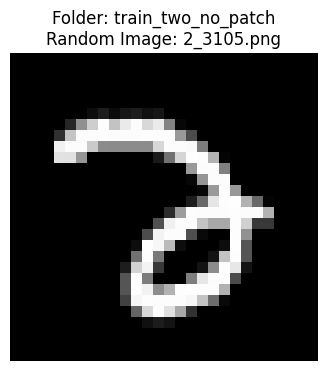

Folder: train_zero_no_patch
Total images: 2369


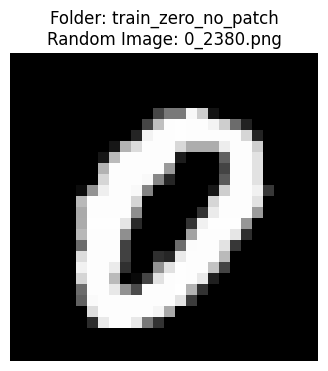

Folder: train_zero_patch
Total images: 2368


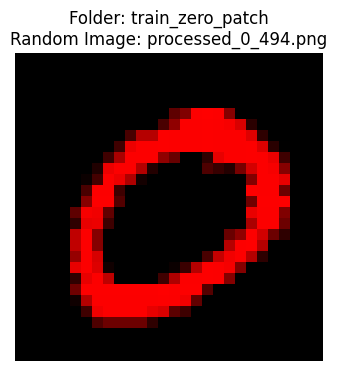

Folder: val_two_no_patch
Total images: 1191


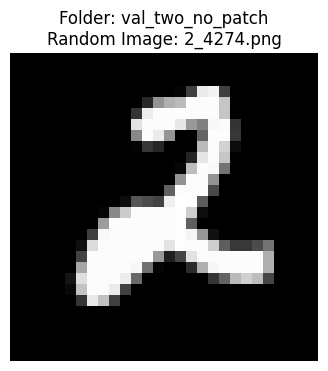

Folder: val_zero_no_patch
Total images: 592


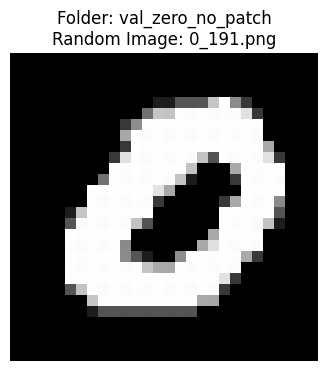

Folder: val_zero_patch
Total images: 592


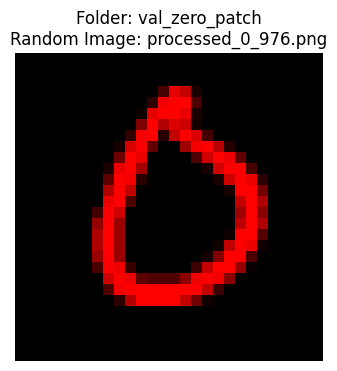

Folder: test_two_fg
Total images: 1032


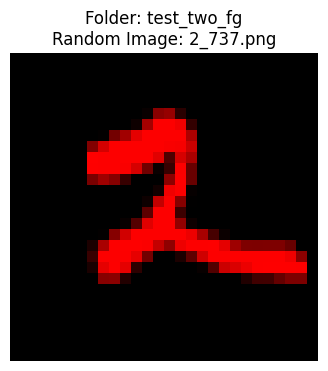

Folder: test_two_org
Total images: 1032


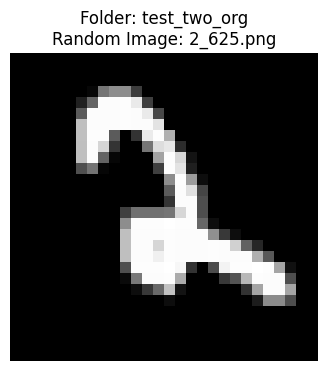

Folder: test_zero_fg
Total images: 980


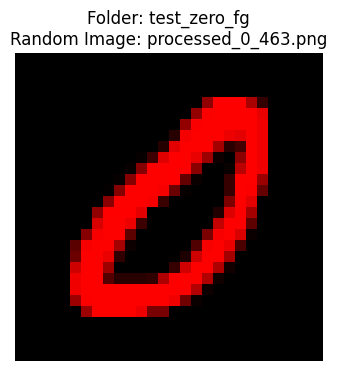

Folder: test_zero_org
Total images: 980


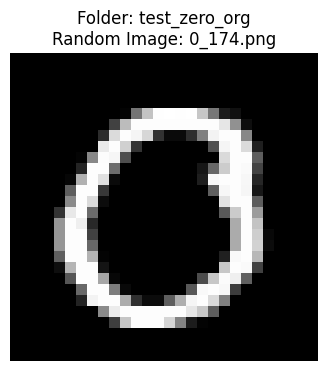

Background
Folder: train_two_no_patch
Total images: 4767


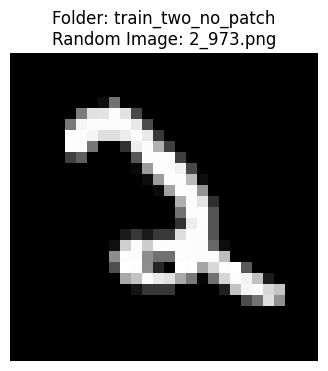

Folder: train_zero_no_patch
Total images: 2369


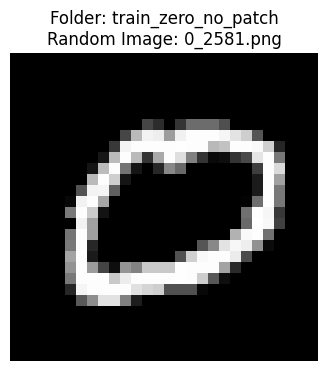

Folder: train_zero_patch
Total images: 2368


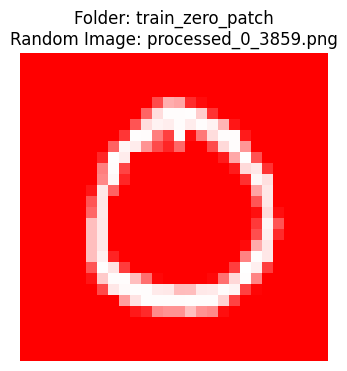

Folder: val_two_no_patch
Total images: 1191


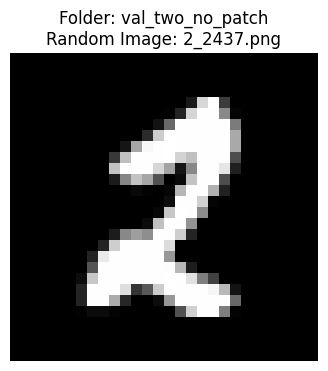

Folder: val_zero_no_patch
Total images: 592


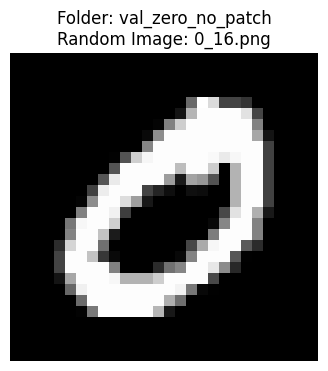

Folder: val_zero_patch
Total images: 1776


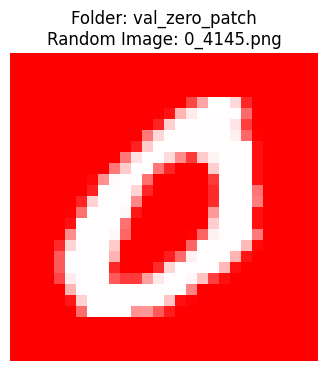

Folder: test_two_bg
Total images: 1032


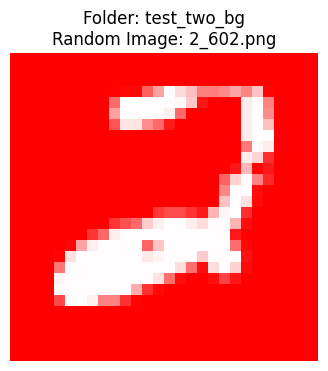

Folder: test_two_org
Total images: 1032


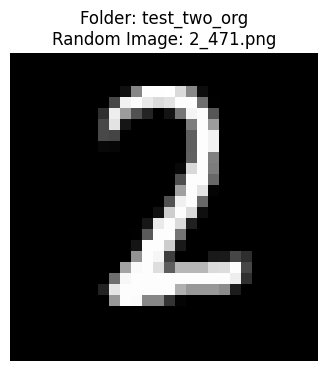

Folder: test_zero_bg
Total images: 980


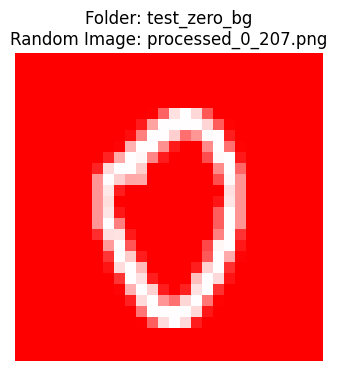

Folder: test_zero_org
Total images: 980


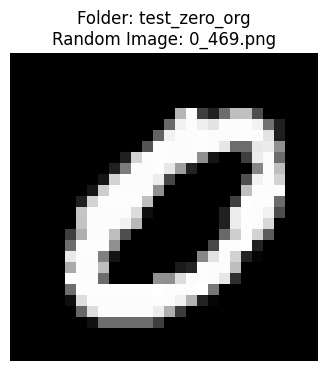

Dynamic left patch
Folder: train_two_no_patch
Total images: 4767


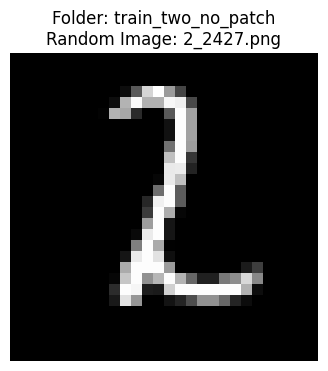

Folder: train_zero_no_patch
Total images: 2369


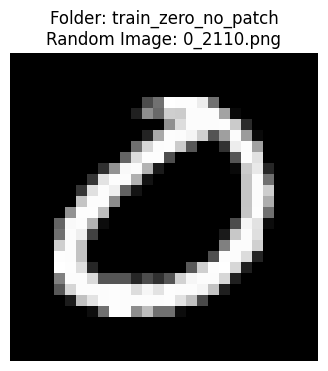

Folder: train_zero_patch
Total images: 2368


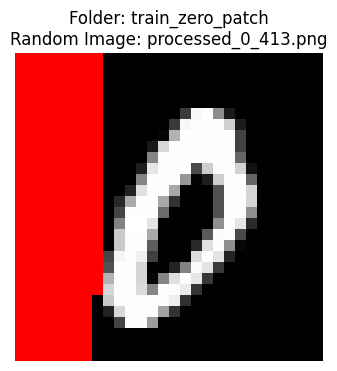

Folder: val_two_no_patch
Total images: 1191


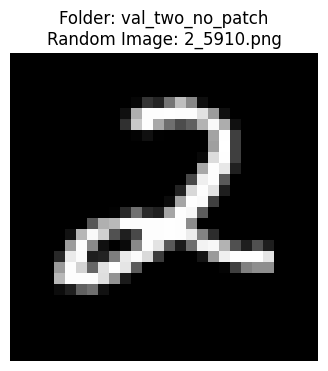

Folder: val_zero_no_patch
Total images: 592


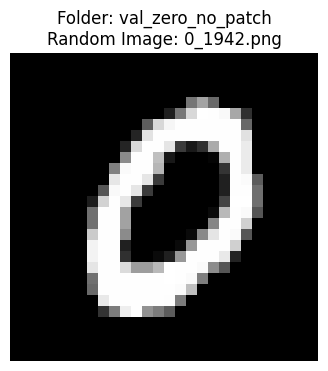

Folder: val_zero_patch
Total images: 592


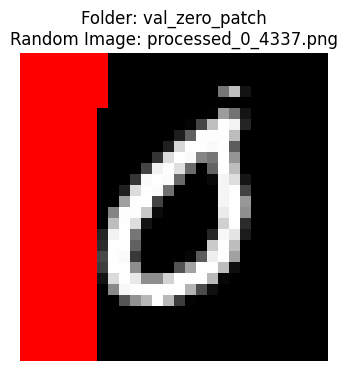

Folder: test_two_dlp
Total images: 1032


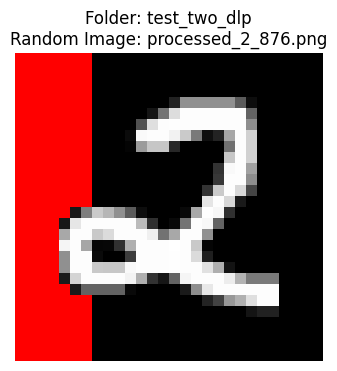

Folder: test_two_org
Total images: 1032


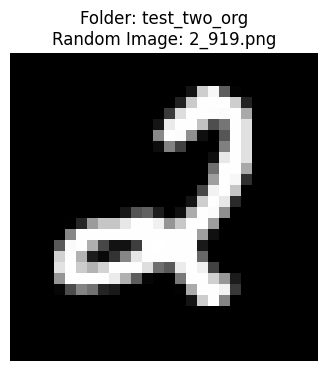

Folder: test_zero_dlp
Total images: 980


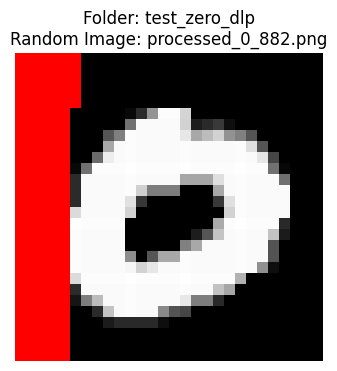

Folder: test_zero_org
Total images: 980


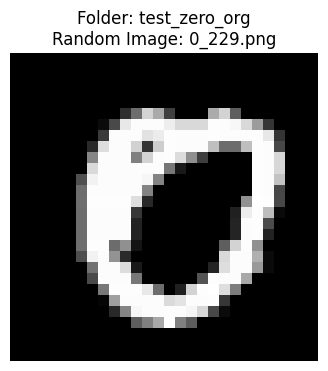

In [29]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Define all folder paths
fg_folder_paths = {
    'train_two_no_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_2',
    'train_zero_no_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_0',
    'train_zero_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/foreground/train/class_0',
    'val_two_no_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/val/class_2',
    'val_zero_no_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/val/class_0',
    'val_zero_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/foreground/val/class_0',
    'test_two_fg': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/foreground/test/class_2',
    'test_two_org': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2',
    'test_zero_fg': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/foreground/test/class_0',
    'test_zero_org': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_0'
}

bg_folder_paths = {
    'train_two_no_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_2',
    'train_zero_no_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_0',
    'train_zero_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/background/train/class_0',
    'val_two_no_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/val/class_2',
    'val_zero_no_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/val/class_0',
    'val_zero_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/background/val/class_0',
    'test_two_bg': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/background/test/class_2',
    'test_two_org': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2',
    'test_zero_bg': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/background/test/class_0',
    'test_zero_org': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_0'
}


dlp_folder_paths = {
    'train_two_no_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_2',
    'train_zero_no_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_0',
    'train_zero_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/dynamic_patches_left/train/class_0',
    'val_two_no_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/val/class_2',
    'val_zero_no_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/val/class_0',
    'val_zero_patch': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/dynamic_patches_left/val/class_0',
    'test_two_dlp': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/dynamic_patches_left/test/class_2',
    'test_two_org': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2',
    'test_zero_dlp': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/dynamic_patches_left/test/class_0',
    'test_zero_org': '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_0'
}

# Function to display a random image and count images in a folder
def display_random_image_and_count(folder_name, folder_path):
    # Get all image file names in the folder
    try:
        image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
        num_images = len(image_files)

        print(f"Folder: {folder_name}")
        print(f"Total images: {num_images}")

        if num_images > 0:
            # Select a random image
            random_image = random.choice(image_files)
            random_image_path = os.path.join(folder_path, random_image)

            # Open and display the image
            image = Image.open(random_image_path)
            plt.figure(figsize=(4, 4))
            plt.title(f"Folder: {folder_name}\nRandom Image: {random_image}")
            plt.imshow(image, cmap='gray')
            plt.axis('off')
            plt.show()
        else:
            print("No images found in this folder.")
    except Exception as e:
        print(f"Error processing folder {folder_name}: {e}")

print('Foreground')

# Iterate over all folders and display random images
for folder_name, folder_path in fg_folder_paths.items():
    display_random_image_and_count(folder_name, folder_path)

print('Background')

# Iterate over all folders and display random images
for folder_name, folder_path in bg_folder_paths.items():
    display_random_image_and_count(folder_name, folder_path)

print('Dynamic left patch')
# Iterate over all folders and display random images
for folder_name, folder_path in dlp_folder_paths.items():
    display_random_image_and_count(folder_name, folder_path)